### Create a model with Advanced Packages - Part 1

This example problem is based on test 1 from the Lake Package documentation ([Merritt and Konikow, 2000](https://doi.org/10.3133/wri004167)). We are going to add a Streamflow Routing (SFR) feature and a Multi-Aquifer Well (MAW) feature to the model.

#### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import flopy
import matplotlib.pyplot as plt
import numpy as np
import pathlib as pl

Define the model name and workspace

In [2]:
name = "ad-p1"
ws = pl.Path(f"./temp/{name}")

#### Define parameters

Define model units, parameters and other settings.

In [3]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 5  # Number of layers
nrow = 17  # Number of rows
ncol = 17  # Number of columns
top = 500.0  # Top of the model (ft)
botm = [107., 97., 87., 77., 67.]  # Bottom elevations (ft)
strt = 115.0  # Starting head (ft)
k11 = 30.0  # Horizontal hydraulic conductivity (ft/d)
k33 = [1179., 30., 30., 30., 30.]  # Vertical hydraulic conductivity (ft/d)
ss = 3e-4  # Specific storage (1/d)
sy = 0.2  # Specific yield (unitless)
H1 = 160.0  # Constant head on left side of model (ft)
H2 = 140.0  # Constant head on right side of model (ft)
recharge = 0.0116  # Aereal recharge rate (ft/d)
etvrate = 0.0141  # Maximum evapotranspiration rate (ft/d)
etvdepth = 15.0  # Evapotranspiration extinction depth (ft)
lak_strt = 110.0  # Starting lake stage (ft)
lak_etrate = 0.0103  # Lake evaporation rate (ft/d)
lak_bedleak = 0.1  # Lakebed leakance (1/d)

# Static temporal data used by TDIS file
tdis_ds = ((5000.0, 100, 1.02),)

# define delr and delc
# fmt: off
delr = np.array(
    [
        250.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0,
        500.00, 500.00, 500.00, 500.0, 500.00, 1000.0,
        1000.0, 1000.0, 1000.0, 1000.0, 250.0,
    ]
)
# fmt: off
delc = np.array(
    [
        250.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0,
        500.00, 500.00, 500.00, 500.0, 500.00, 1000.0,
        1000.0, 1000.0, 1000.0, 1000.0, 250.0,
    ]
)

# Define dimensions
extents = (0.0, delr.sum(), 0.0, delc.sum())
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)



# create linearly varying evapotranspiration surface
xlen = delr.sum() - 0.5 * (delr[0] + delr[-1])
x = 0.0
s1d = H1 * np.ones(ncol, dtype=float)
for idx in range(1, ncol):
    x += 0.5 * (delr[idx - 1] + delr[idx])
    frac = x / xlen
    s1d[idx] = H1 + (H2 - H1) * frac
surf = np.tile(s1d, (nrow, 1))

# Create the array defining the lake location
lake_map = np.ones(shape3d, dtype=np.int32) * -1
lake_map[0, 6:11, 6:11] = 0
lake_map[1, 7:10, 7:10] = 0
lake_map = np.ma.masked_where(lake_map < 0, lake_map)

# update the evapotranspiration using the lake map 
surf[lake_map[0] == 0] = botm[0] - 2
surf[lake_map[1] == 0] = botm[1] - 2

# Constant head boundary conditions
chd_spd = []
for k in range(nlay):
    chd_spd += [[k, i, 0, H1] for i in range(nrow)]
    chd_spd += [[k, i, ncol - 1, H2] for i in range(nrow)]

# LAK Package
lak_spd = [
    [0, "rainfall", recharge],
    [0, "evaporation", lak_etrate],
]

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Plot the lake locations

C:\Users\mpedraza\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\mpedraza\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\mpedraza\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


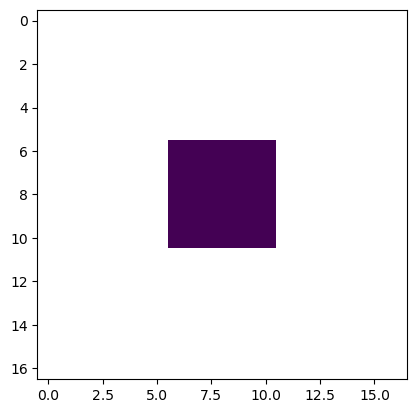

In [4]:
plt.imshow(lake_map[0]);

### Model setup

Create the MODFLOW packages for standard packages.

In [5]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(
    sim,
    print_option="summary",
    linear_acceleration="bicgstab",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose} strict",
)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=name, newtonoptions="newton", save_flows=True
)
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    idomain=np.ones(shape3d, dtype=int),
    top=top,
    botm=botm,
)

# create groundwater head observations
obs_file = f"{name}.gwf.obs"
csv_file = obs_file + ".csv"
obslist = [
    ["A", "head", (0, 3, 3)],
    ["B", "head", (0, 13, 13)],
    ["SFR", "head", (0, 8, 11)],
]
obsdict = {csv_file: obslist}
flopy.mf6.ModflowUtlobs(
    gwf, filename=obs_file, print_input=False, continuous=obsdict
)

flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=1,
    k=k11,
    k33=k33,
    save_specific_discharge=True,
)

flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=1,
    sy=sy,
    ss=ss,
)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=etvrate, depth=etvdepth)



flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("BUDGET", "ALL"), ("HEAD", "LAST")]
);



### Create the Lake Package

Create the lake connectivity

In [6]:
(
    idomain_wlakes,
    pakdata_dict,
    lak_conn,
) = flopy.mf6.utils.get_lak_connections(
    gwf.modelgrid,
    lake_map,
    bedleak=lak_bedleak,
)

### Create the lake package object

Use the lake package data to create the Lake package

In [7]:
lak_packagedata = [[0, lak_strt, pakdata_dict[0]]]
lak = flopy.mf6.ModflowGwflak(
    gwf,
    print_stage=True,
    nlakes=1,
    noutlets=0,
    packagedata=lak_packagedata,
    connectiondata=lak_conn,
    perioddata=lak_spd,
)

### Create Lake observations

In [8]:
obs_file = f"{name}.lak.obs"
csv_file = obs_file + ".csv"
obs_dict = {
    csv_file: [
        ("stage", "stage", (0,)),
    ]
}
lak.obs.initialize(
    filename=obs_file, digits=10, print_input=True, continuous=obs_dict
)

Update the idomain to inactivate the lake area

In [9]:
gwf.dis.idomain = idomain_wlakes

### Add the SFR feature

The SFR reaches will be in row 8 starting in columns 11 to 15 (zero-based).

In [10]:
nreaches = 5
bed_elev = [142., 141.5, 141., 141.5, 141.]
upstfr = [0., 1., 1., 1., 1.]
nconn = [1, 2, 2, 2, 1]

In [11]:
#<ifno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv>
sfr_pakdata = [(idx, (0, 8, 11 + idx), 1000., 25., 1e-3, bed_elev[idx], 1.0, 0.1, 0.035, nconn[idx], upstfr[idx], 0, "sfr") for idx in range(nreaches)]
sfr_pakdata

[(0,
  (0, 8, 11),
  1000.0,
  25.0,
  0.001,
  142.0,
  1.0,
  0.1,
  0.035,
  1,
  0.0,
  0,
  'sfr'),
 (1,
  (0, 8, 12),
  1000.0,
  25.0,
  0.001,
  141.5,
  1.0,
  0.1,
  0.035,
  2,
  1.0,
  0,
  'sfr'),
 (2,
  (0, 8, 13),
  1000.0,
  25.0,
  0.001,
  141.0,
  1.0,
  0.1,
  0.035,
  2,
  1.0,
  0,
  'sfr'),
 (3,
  (0, 8, 14),
  1000.0,
  25.0,
  0.001,
  141.5,
  1.0,
  0.1,
  0.035,
  2,
  1.0,
  0,
  'sfr'),
 (4,
  (0, 8, 15),
  1000.0,
  25.0,
  0.001,
  141.0,
  1.0,
  0.1,
  0.035,
  1,
  1.0,
  0,
  'sfr')]

Create the connectivity data for the SFR reaches

In [12]:
sfr_conn = []
for idx in range(nreaches):
    c = [idx]
    if idx > 0:
        c.append(idx - 1)
    if idx - 1 < nreaches:
        c.append(-(idx + 1))
    sfr_conn.append(c)
sfr_conn
    

[[0, -1], [1, 0, -2], [2, 1, -3], [3, 2, -4], [4, 3, -5]]

### Create SFR observations

In [13]:
    obs_file = f"{name}.sfr.obs"
    csv_file = obs_file + ".csv"
    obs_dict = {
        obs_file + ".csv": [
            ("baseflow", "SFR", "SFR"),
            ("outflow", "ext-outflow", (4,)),
            ("stage", "stage", (0,)),
        ]
    }

Use the SFR package data to create the package

In [14]:
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    boundnames=True,
    print_input=True,
    print_flows=True,
    print_stage=True,
    length_conversion=3.28081,
    time_conversion=86400.,
    nreaches=nreaches,
    packagedata=sfr_pakdata,
    connectiondata=sfr_conn,
    observations=obs_dict,
)

### Create the Multi-Aquifer Well Package

In [15]:
maw_row, maw_col = 3, 13
maw_radius = 0.5 
maw_rate = -10000.

In [16]:
maw_packagedata = [[0, maw_radius, botm[-1], strt, "THIEM", 5]]
maw_conn = [(0, idx, (idx, maw_row, maw_col), top, botm[-1], -999.0, -999.0) for idx in range(nlay)]
maw_spd = [[0, "rate", maw_rate]]

### Create the MAW package from the MAW data

In [17]:
maw = flopy.mf6.ModflowGwfmaw(
        gwf,
        nmawwells=1,
        packagedata=maw_packagedata,
        connectiondata=maw_conn,
        perioddata=maw_spd,
    )

### Write the model files

In [18]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ad-p1...
    writing model name file...
    writing package dis...
    writing package obs_0...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 170 based on size of stress_period_data
    writing package rcha_0...
    writing package evta_0...
    writing package oc...
    writing package lak_0...
    writing package obs_1...
    writing package sfr_0...
    writing package obs_2...
    writing package maw_0...


### Run the model

In [19]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\AppData\Local\miniforge3\envs\mfandmore2024\Scripts\mf6.exe


PermissionError: [WinError 5] Access is denied

### Plot Results


In [ ]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)

In [ ]:
# load the observations
lak_results = gwf.lak.output.obs().data
sfr_results = gwf.sfr.output.obs().data
gwf_results = gwf.obs[0].output.obs().data

In [ ]:
# create MODFLOW 6 head object
hobj = gwf.output.head()

# create MODFLOW 6 cell-by-cell budget object
cobj = gwf.output.budget()

kstpkper = hobj.get_kstpkper()

head = hobj.get_data(kstpkper=kstpkper[0])
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0],
gwf,
)

# add lake stage to heads
head[head == 1e30] = lak_results["STAGE"][-1]

# observation locations
xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]
p1 = (xcenters[3], ycenters[3])
p2 = (xcenters[13], ycenters[13])


#### Plot the heads

In [ ]:
fig, axd = plt.subplot_mosaic(
    [
        ["a"],
        ["a"],
        ["b"],
    ],
    layout="constrained", 
    figsize=(4, 6.9),
    )

ax = axd["a"]
mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
mm.plot_bc("CHD", color="cyan")
mm.plot_inactive(color_noflow="#5DBB63")
mm.plot_grid(lw=0.5, color="black")
cv = mm.contour_array(
    head,
    levels=np.arange(140, 160, 2),
    linewidths=0.75,
    linestyles="-",
    colors="blue",
)
plt.clabel(cv, fmt="%1.0f")
mm.plot_vector(qx, qy, normalize=True, color="0.75")
ax.plot(p1[0], p1[1], marker="o", mfc="red", mec="black", ms=4)
ax.plot(p2[0], p2[1], marker="o", mfc="red", mec="black", ms=4)
ax.set_xlabel("x-coordinate, in feet")
ax.set_ylabel("y-coordinate, in feet")

ax = axd["b"]
xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 8})
xs.plot_array(np.ones(shape3d), head=head, cmap="jet")
xs.plot_bc("CHD", color="cyan", head=head)
xs.plot_ibound(color_noflow="#5DBB63", head=head)
xs.plot_grid(lw=0.5, color="black")
ax.set_xlabel("x-coordinate, in feet")
ax.set_ylim(67, 160)
ax.set_ylabel("Elevation, in feet")


plt.show()




#### Plot the stage results

In [20]:
dtype = [
    ("time", float),
    ("STAGE", float),
    ("A", float),
    ("B", float),
    ("SFR STAGE", float),
]

results = np.zeros((lak_results.shape[0] + 1), dtype=dtype)
results["time"][1:] = lak_results["totim"]
results["STAGE"][0] = 110.0
results["STAGE"][1:] = lak_results["STAGE"]
results["A"][0] = 115.0
results["A"][1:] = gwf_results["A"]
results["B"][0] = 115.0
results["B"][1:] = gwf_results["B"]
results["SFR STAGE"][1:] = sfr_results["STAGE"]

# create the figure
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    sharex=True,
    figsize=(6.3, 3.15),
    constrained_layout=True,
)

ax.set_xlim(0, 3000)
ax.set_ylim(110, 160)
ax.plot(
    results["time"],
    results["STAGE"],
    lw=0.75,
    ls="--",
    color="black",
    label="Lake stage",
)
ax.plot(
    results["time"],
    results["SFR STAGE"],
    lw=0.75,
    ls=":",
    color="black",
    label="Reach stage",
)
ax.plot(
    results["time"],
    results["A"],
    lw=0.75,
    ls="-",
    color="0.5",
    label="Point A",
)
ax.plot(
    results["time"],
    results["B"],
    lw=0.75,
    ls="-",
    color="black",
    label="Point B",
)
ax.set_xlabel("Simulation time, in days")
ax.set_ylabel("Head or stage, in feet")
plt.legend(loc="lower right")

plt.show()


NameError: name 'lak_results' is not defined

#### Plot the SFR flow observations

In [ ]:
dtype = [
    ("time", float),
    ("OUTFLOW", float),
    ("BASEFLOW", float),
]

results = np.zeros((sfr_results.shape[0] + 1), dtype=dtype)
results["time"][1:] = sfr_results["totim"]
results["OUTFLOW"][1:] = sfr_results["OUTFLOW"]
results["BASEFLOW"][1:] = sfr_results["BASEFLOW"]

# create the figure
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    sharex=True,
    figsize=(6.3, 3.15),
    constrained_layout=True,
)

ax.set_xlim(0, 3000)
# ax.set_ylim(110, 160)
ax.plot(
    results["time"],
    results["OUTFLOW"],
    lw=0.75,
    ls="--",
    color="black",
    label="Reach outflow",
)
ax.plot(
    results["time"],
    results["BASEFLOW"],
    lw=0.75,
    ls=":",
    color="black",
    label="Reach baseflow",
)
ax.set_xlabel("Simulation time, in days")
ax.set_ylabel("Flow, in feet per day")
plt.legend(loc="lower right")

plt.show()